# Проект: классификация

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 1. Знакомство с данными, обработка пропусков и выбросов

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<p style = "background-color : #afeeee; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Импортируем библиотеки используемые в работе:</span>

In [431]:
# Расчёты
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Обучение, опитимизация, метрики
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model,tree, ensemble, metrics, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import optuna

# Подавления сообщений об ошибках 
import warnings
warnings.filterwarnings('ignore')

# Для распечатки в цвете:
from termcolor import colored


# Для рандома цветов
import random

<div class="alert alert-info">
    
 Оценим, насколько предложенные данные готовы к дальнейшему анализу

In [432]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


<div class="alert alert-info">

- <span style="color:#191970">**age**</span> -  (возраст);
- <span style="color:#191970">**job**</span> - (сфера занятости);
- <span style="color:#191970">**marital**</span> - (семейное положение);
- <span style="color:#191970">**education**</span> - (уровень образования);
- <span style="color:#191970">**default**</span> - (имеется ли просроченный кредит);
- <span style="color:#191970">**housing**</span> - (имеется ли кредит на жильё);
- <span style="color:#191970">**loan**</span> - (имеется ли кредит на личные нужды);
- <span style="color:#191970">**balance**</span> - (баланс).
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- <span style="color:#191970">**contact**</span> - (тип контакта с клиентом);
- <span style="color:#191970">**month**</span> - (месяц, в котором был последний контакт);
- <span style="color:#191970">**day**</span> - (день, в который был последний контакт);
- <span style="color:#191970">**duration**</span> - (продолжительность контакта в секундах).
Прочие признаки:

- <span style="color:#191970">**campaign**</span> - (количество контактов с этим клиентом в течение текущей кампании);
- <span style="color:#191970">**pdays**</span> - (количество пропущенных дней с момента последней маркетинговой кампании до контакта - <span style="color:#191970">**в текущей кампании);
- <span style="color:#191970">**previous**</span> - (количество контактов до текущей кампании)
- <span style="color:#191970">**poutcome**</span> - (результат прошлой маркетинговой кампании).

In [433]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
print(colored('Смотрим типы данных и наличие пропусков:\n', 'blue'))
df.info()
print(colored(f'\n- Количество столбцов:{df.shape[1]}','blue'))
print(colored(f'- Количество строк: {df.shape[0]}','blue'))
print(colored(f'- Количество дубликатов: {df[df.duplicated()].shape[0]}','blue'))

for col in df.columns:
    col_null = df[df[col].isnull()].shape[0]
    if col_null > 0:
        print(colored(f'- Количество пропусков в признаках:\n "{col}": {col_null} шт','blue'))

Смотрим типы данных и наличие пропусков:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB

- Количество столбцов:17
- Количество строк: 11162
- Кол

<div class="alert alert-warning alert-dismissible">
  Среди данных дубликатов не обнаружено, но присутвуют пропуска, и есть необходимость корректировки признака, путем приведения в корректный числовой формат.


In [434]:
# Сделаем копию датафрейма, чтобы исключить возможные нарушение в изначальных данных
df_c = df.copy()

In [435]:
# Преобразуйем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_c['balance'] = df_c['balance'].replace({'\$': '',
                                       ',': '.',
                                       ' ': ''}, regex=True).astype(float)
# Проверка типа данных
balance_type = df_c['balance'].dtype
print(f'Тип колонки balance после преобразования: {balance_type}')

# Взглянем на средний баланс:
m_balance = round(df_c['balance'].mean(),2)
print(f'Средний баланс равен: {m_balance}')

Тип колонки balance после преобразования: float64
Средний баланс равен: 1529.13


In [436]:
# Обработаем пропуски в признаке balance, заменив их на медианные значения по данному признаку
df_c['balance'] = df_c['balance'].fillna(df_c['balance'].median())

# Выполним проверку замены, и повторно взглянем на средний баланс:
m_balance_edit = round(df_c['balance'].mean(),2)
print(f'Средний баланс равен: {m_balance_edit}')

Средний баланс равен: 1526.94


Взглянем на признаки работы `['job']` и образования `['education']`

In [437]:
# Провереем признак 'job'
df_c.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [438]:
# Провереем признак 'education'
df_c.education.value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

<div class="alert alert-warning alert-dismissible">
 Признаки имеют неизвестные значения <strong>unknown</strong>, количество не значительное, но не будем игнорировать и проведем обработку

In [439]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
edit_list = ['job', 'education']
for col in edit_list:
    modal_value = df_c[col].mode()[0]
    df_c[col] = df_c[col].replace('unknown', modal_value)

<div class="alert alert-info">

Теперь проведем обзор на возможные выбросы признака **['balance']**.

В математической статистике есть несколько подходов, позволяющих определить наличие выбросов.
Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха **(Q1−1.5∗IQR )**, а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. **(Q1+1.5∗IQR)**. Найдём эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось.

In [440]:
# Создадим функцию для определения возможных выбросов:
def get_iqr(data, col):
    """Определяем границы диапазонов для ограничения значений по методу Тьюки
    
    Args:
        data: датасет
        col: Колонка по которой проводится расчёт
    
    Return:
        Результаты расчётов верхней и нижней границы диапазонов
    """  
    
    x = data[col]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return {'lower_bound': lower_bound, 'upper_bound': upper_bound}

In [441]:
# Вывод границ:
bounds = get_iqr(df_c, 'balance')
print(f"Нижняя граница поиска выбросов по методу Тьюки: {bounds['lower_bound']}")
print(f"Верхняя граница поиска выбросов по методу Тьюки: {bounds['upper_bound']}")

# Уберем данные с выбросами
df_c = df_c[(df_c['balance'] >= bounds['lower_bound']) & (df_c['balance'] <= bounds['upper_bound'])]

# Выведем обновленную информацию количеству колонок в датафрейме:
print(f'Количество колонок в DataFrame: {df_c.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: -2241.0
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Количество колонок в DataFrame: 10105


<div class="alert alert-success">
  - Определены и убраны выбросы из датасета<br>
  - Обработаны возможные пропуска
</div>


<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 2:  Разведывательный анализ

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

<div class="alert alert-info">

Взглянем на сбалансированность исследуемого признака


In [442]:
# Построение графика

fig = px.histogram(df_c,
                   x='deposit',
                   width=700,
                   height=500,
                   color="deposit", 
                   color_discrete_sequence=['#adff2f', '#dc143c'] # заданные цвета для колонок
                   )

# Настройка осей графика:
fig.update_layout(
    # Название графика
    title=dict(
        text='Статус депозита клиента', # Название
        font=dict(size=20, color= "black"), # Шрифт, цвет названия
        x=0.5 # заголовок центруем
        ),
    # Название осей
    xaxis=dict(title = "",
        tickmode='array', # режим размещения делений
        tickvals=[1, 0], # значение делений на оси
        ticktext=['Не открыт', 'Открыт'] # текст отображаемый на делениях
    ),
    yaxis_title="Количество клиентов", # Название оси y
    yaxis_tickformat='.0f', # Формат отображение по оси y
    margin=dict(l=0, r=0, t=30, b=0),
    showlegend = False, # Убираем легенду
    bargap = 0.2 # Расстояние между колонок
    )


# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="Клиентов: %{y}<br>", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=2.5,       # Толщина линии колонки
    opacity=1            # Прозрачность колонки
)
fig.show();

<div class="alert alert-info">

В очищенных данных статус **депозита** практически сбалансирован

In [443]:
# Создадим функцию построения графиков по количественным признаков
# для визуального восприятия информации

def quant_fig(x, layout_name, xaxis_title):
    """Функция построения графиков для количественных переменных

    Args:
        x (_str_): Название колонки из Dataframe для расчёта моды и построения графика
        layout_name (_str_): Название графика
        xaxis_title (_str_): Название оси X
    """    
    # Вычисляем моду, это понадобится для выделение моды на графике
    mode = df_c[x].mode()[0]
    
    # Для большей красоты визуализации генерируем случайный цвет,
    # чтобы каждый график был новым цветом (генерируются три случайных числа в диапазоне от 0 до 255.
    # Затем эти числа вставляются в строку в формате RGB с помощью f-строки)
    random_color = f'rgb({random.randint(0, 255)}, ' \
                   f'{random.randint(0, 255)}, ' \
                   f'{random.randint(0, 255)})'
    
    # Строим график
    fig = px.histogram(
        df_c, # df
        x = x, # x
        marginal='box',
        nbins=100,
        width=1000,
        height=500,
        color_discrete_sequence=[random_color] # цветовая палитра
    )

    # Устанавливаем название графика, размеры текста и наименование осей:
    fig.update_layout(
        title={
            'text': f'Распределение {layout_name}',
            'y':0.97,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
        title_font={
            'size':18,
            'color':"black"
            },
        xaxis_title=f'{xaxis_title}',
        yaxis_title='Количество'
    )

    # Добавляем обводку колонок
    fig.update_traces(
        hoverinfo="all",
        hovertemplate=f'{xaxis_title}: %{{x}}<br> Количество: %{{y}}',
        marker_line_color='black',   # Цвет линии колонки
        marker_line_width=1.0,       # Толщина линии колонки
        opacity=0.9            # Прозрачность колонки
    )

    # Устанавливаем дополнительную линию моды на графике:
    fig.add_vline(
        x=mode,
        line_width=2, 
        line_color="black", 
        annotation_text=f"Мода распределения: {mode}",
        annotation_position='bottom left'
    )

    # Упростим чтение визуализации добавив "шпильки" на оси:
    fig.update_xaxes(showspikes=True)
    fig.update_yaxes(showspikes=True)
    
    fig.show()

In [444]:
quant_fig('age', 'возраста клиента', 'Возраст лет')

In [445]:
quant_fig('duration', 'продолжительности контакта с клиентом', 'Продолжительность контакта, сек')

In [446]:
quant_fig('balance', 'баланс клиента', 'Баланс, $')

In [447]:
quant_fig('campaign', 'количества контактов с клиентом в течение текущей компании', 'Количество контактов')

In [448]:
quant_fig('pdays', 'пропущенных дней с момента последней маркетинговой компании', 'Количество пропущенных дней')

In [449]:
quant_fig('previous', 'количества контактов до текущей компании', 'Контактирований с клиентом, раз')

In [450]:
# Получим статистическую информацию по признакам:
df_c.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<div class="alert alert-danger fade show">
  Выводы!

 + Так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним, при дальнейшем исследовании так и сделаем, разделим на подгруппы возраст

<div class="alert alert-info">

Создайдим новую переменную, в которой будут находиться индикаторы принадлежности к одной из следующих категорий:
- **<30**;
- **30-40**;
- **40-50**;
- **50-60**;
- **60+**.

In [451]:
df_c['age_group'] = pd.cut(df_c.age, [0,30,40,50,60,9999],
                            labels = ['<30','30-40','40-50','50-60','60+'])

<div class="alert alert-info">

А теперь изучим распределение целевой переменной по признакам

In [452]:
def cat_graph(x):
    """Построение графиков распределения целевой переменной по признакам

    Args:
        x (_str_): интересующий нас признак
    """    
    df_pivot = df_c.pivot_table(index=x, # исследуемый признак
                                columns='deposit', # столбцы по которым разделяем признак
                                aggfunc='size' # параметр агрегации для подсчета вхождений
                                )

    color_sequence = ['#ff4f00', '#0014a8'] # Цветовая палитра 
    
    fig = px.bar(
        df_pivot,
        x=df_pivot.columns,
        y=df_pivot.index,
        width=1000,
        height=500,
        barmode="group",
        color_discrete_sequence=color_sequence,
        title=f'Распределение открытия депозита (признак {x})',
    )

    fig.update_layout(
        title={
            'text': f'Распределение открытия депозита (признак {x})',
            'y':0.97,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
            },
        title_font={
            'size':18,
            'color':"black"
            },
        xaxis_title="Количество",
        yaxis_title="Категории",
        yaxis_tickformat=',.2f',
        margin=dict(l=0, r=0, t=30, b=0),
        legend_title = 'Статус открытия депозита',
    )
        
    fig.update_traces(
        hoverinfo="all",
        hovertemplate=f'Количество: %{{x}}',
        marker_line_color='black',   # Цвет линии колонки
        marker_line_width=1.0,       # Толщина линии колонки
        opacity=0.8            # Прозрачность колонки
    )     

    fig.show()

In [453]:
# Создадим список с интересующими нас колонками
column_list = ['age_group', 'job', 'marital', 'education', 'month', 'contact']

# Строим графики
for col in column_list:
    cat_graph(col)

<div class="alert alert-danger fade show">
  Выводы!

### Задание 11

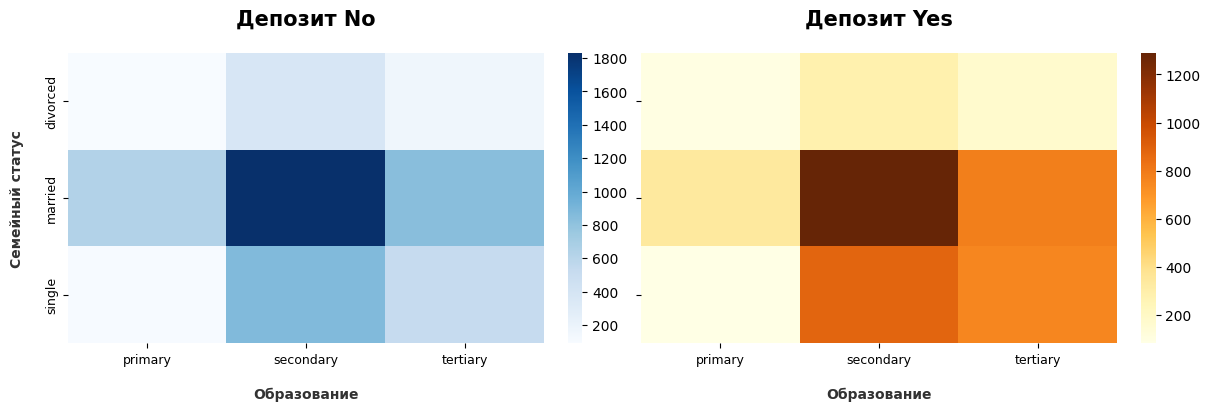

In [454]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Создаем 2 новых df с условиями статуса deposit
m_e_deposit_n = df_c[df_c['deposit'] == 'no'][['marital','education']]
m_e_deposit_y = df_c[df_c['deposit'] == 'yes'][['marital','education']]

# Создаем две кросс таблицы
no_deposit = pd.crosstab(m_e_deposit_n['marital'], m_e_deposit_n['education'])
yes_deposit = pd.crosstab(m_e_deposit_y['marital'], m_e_deposit_y['education'])


# Строим тепловые карты
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True, sharey=True)

# sns.heatmap(кросс таблица, ось(график), цвет);
sns.heatmap(no_deposit, ax = ax1, cmap="Blues");
sns.heatmap(yes_deposit, ax = ax2, cmap="YlOrBr");

# ax1.set_xlabel('Название оси, размер шрифта, расстояние от оси)
        #fontdict = {цвет : '#323232', 'насыщенность текста' : 'bold'})
ax1.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})
ax1.set_ylabel('Семейный статус', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})

# ax1.set_title('Название графика', размер шрифта, 'насыщенность текста' : 'bold', расстояние от графика)
ax1.set_title('Депозит No', fontsize=15, fontweight = 'bold', pad = 20)

ax2.set_xlabel('Образование', fontsize=10, labelpad = 15,
           fontdict = {'color' : '#323232', 'fontweight' : 'bold'})
ax2.set_title('Депозит Yes', fontsize=15, fontweight = 'bold', pad = 20)
ax2.set_ylabel('')

ax1.tick_params(axis='both', which='major', labelsize=9);
ax2.tick_params(axis='both', which='major', labelsize=9);

<div class="alert alert-danger fade show">
  Выводы!

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 3: преобразование данных

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

### Задание 1

In [455]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

# Создание экземпляра LabelEncoder
LE=LabelEncoder()
df_c['education'] = LE.fit_transform(df_c['education'])
df_c['age_group'] = LE.fit_transform(df_c['age_group'])

# ?
df_c['education'].sum()

11995

### Задания 2 и 3

In [456]:
LB = LabelBinarizer()
df_c['deposit'] = LB.fit_transform(df_c['deposit'])


# ?
df_c['deposit'].std().round(3)

0.499

In [457]:
df_c['default'] = LB.fit_transform(df_c['default'])
df_c['housing'] = LB.fit_transform(df_c['housing'])
df_c['loan'] = LB.fit_transform(df_c['loan'])

# ?
(df_c['housing'].mean() + df_c['default'].mean() + df_c['loan'].mean()).round(3)

0.635

### Задание 4

In [458]:
df_x = pd.get_dummies(df_c, columns=['job','marital','contact','month','poutcome'])

### Задания 5 и 6

Text(0.5, 1.0, 'Корреляционная матрица')

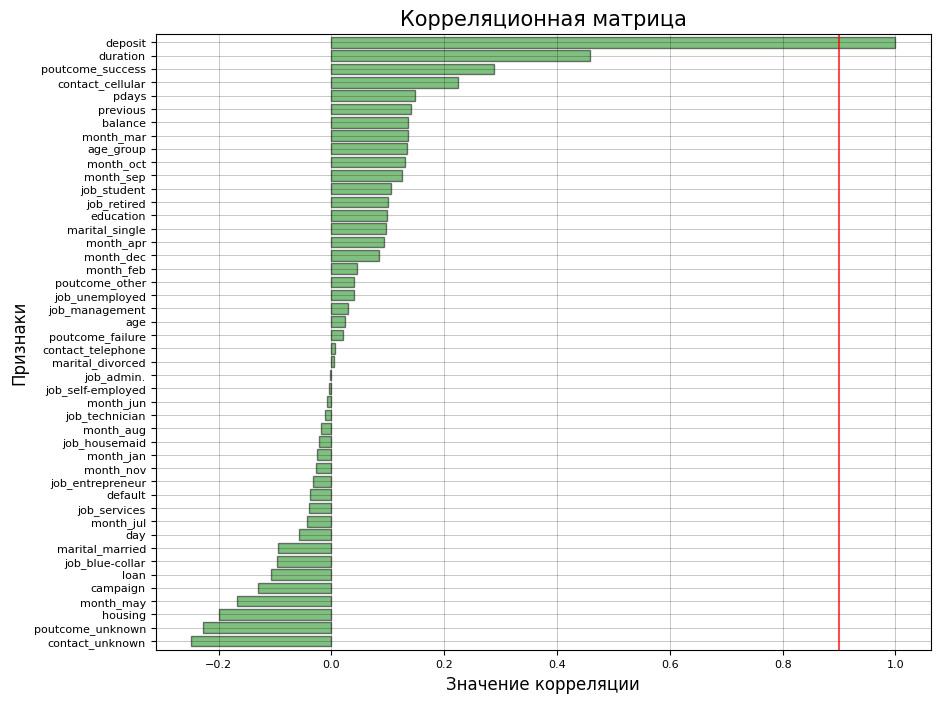

In [459]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

# вычисляем матрцу
corr = df_x.corr()

# Cтроим график
plt.figure(figsize=(10, 8))

# corr[col].sort_values().plot.barh(color=цвет, edgecolor=цвет обводки,
# linewidth=толщина обводки, width=ширина колонки, alpha=прозрачность колонки)
corr["deposit"].sort_values().plot.barh(color='green', edgecolor='black', linewidth=1, width=0.8, alpha=0.5)

# Названия осей и визуальные вид их
plt.xlabel("Значение корреляции", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.grid(Присутствие сетки на графике(True or False), linestyle=вид,  linewidth=толщина линии, 
# alpha=прозрачность сетки, color=цвет)
plt.grid(True, linestyle='-',  linewidth=0.5, alpha=0.3, color='black')

# Задаем отметку линии мультиколлениарности
# plt.axvline(ось=значение, color=цвет, linestyle=вид, alpha=прозрачность)
plt.axvline(x=0.9, color='red', linestyle='-', alpha=0.7)

plt.title("Корреляционная матрица", fontsize=15)

### Задания 7 и 8

> Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется **стратифицированным (stratified)**. Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

**Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.**

In [460]:
X = df_x.drop(['deposit'], axis=1)
y = df_x['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

print(colored('Определим соотношения классов в каждом из наборов данных:', 'green'))
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_test.value_counts(normalize=True), sep='')
print('\n')
print(colored('Размеры выборок:', 'green'))
print(f'X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'X_test={X_test.shape}, y_test={y_test.shape[0]}')

Определим соотношения классов в каждом из наборов данных:
Train:
deposit
0    0.53678
1    0.46322
Name: proportion, dtype: float64
Valid:
deposit
0    0.536732
1    0.463268
Name: proportion, dtype: float64


Размеры выборок:
X_train=(6770, 45), y_train=6770
X_test=(3335, 45), y_test=3335


*Теперь в каждом из наборов данных одинаковые соотношения классов — 54/46. Метрики, полученные при одинаковых соотношениях на выборках, будут более объективными.*

### Задание 9

In [461]:
# с помощью SelectKBest отберём 15 наиболее подходящих признаков

# Создаем экземпляр SelectKBest
selector = SelectKBest(score_func=f_classif, k=15)

# Применяем SelectKBest к данным X и y
selector.fit(X_train, y_train)

selectKBest_columns = list(selector.get_feature_names_out())
selectKBest_columns_list = '\n'.join(selectKBest_columns)
print(f"Выбранные наилучших признаки для модели:\n{selectKBest_columns_list}")

Выбранные наилучших признаки для модели:
balance
housing
duration
campaign
pdays
previous
age_group
contact_cellular
contact_unknown
month_mar
month_may
month_oct
month_sep
poutcome_success
poutcome_unknown


### Задание 10

In [462]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

scaler.fit(X_train[selectKBest_columns])                           
X_train_scaled = scaler.transform(X_train[selectKBest_columns])    
X_test_scaled = scaler.transform(X_test[selectKBest_columns])      
round(X_test_scaled[:,0].mean(),2)

0.47

<div class="alert alert-danger fade show">
  Выводы!

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

### Задание 1

In [463]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(round(accuracy,2))

0.81


### Задания 2,3,4

In [464]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf_2d = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=6, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
dt_clf_2d.fit(X_train_scaled, y_train)

y_train_pred = dt_clf_2d.predict(X_train_scaled)
y_pred = dt_clf_2d.predict(X_test_scaled)

print(f"Accuracy для трейн выборки:{round(metrics.accuracy_score(y_train, y_train_pred),2)}")
print(f"Accuracy для тестовой выборки:{round(metrics.accuracy_score(y_test, y_pred),2)}")


Accuracy для трейн выборки:0.82
Accuracy для тестовой выборки:0.81


### Задание 5

In [465]:
# подберите оптимальные параметры с помощью gridsearch


In [466]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1
)  

%time grid_search.fit(X_train_scaled, y_train) 

print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

y_test_pred = grid_search.predict(X_test_scaled)
metrics_test = round(metrics.f1_score(y_test, y_test_pred), 2)
print(f"Наилучшее значение f1: {metrics_test}")



CPU times: total: 0 ns
Wall time: 84 ms
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}
Наилучшее значение f1: 0.8


<div class="alert alert-danger fade show">
  Выводы!

<a id='1'></a>
<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

<p style = "background-color : #79d1ff; border-radius: 5px 5px; padding : 10px"><strong>

### Задание 1

In [467]:
# обучите на ваших данных случайный лес
# обучите на ваших данных случайный лес
#Создаём объект класса RandomForestClassifier
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf=5,
    max_depth=10, #максимальная глубина дерева
    # max_features='sqrt', #число признаков из метода случайных подпространств
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)
 
# train_scores.append(round(metrics.accuracy_score(y_train, y_train_pred),2))
# test_scores.append(round(metrics.accuracy_score(y_test, y_pred),2))

#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test_scaled)
#Выводим отчёт о метриках
# print(metrics.classification_report(y_test, y_pred))

print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Рассчитываем precision
# print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.83
Recall: 0.83
F1 score: 0.82


### Задания 2 и 3

In [468]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_pred = gb.predict(X_test_scaled)

print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
#Рассчитываем precision
# print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
#Рассчитываем F1-меру
print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

Accuracy: 0.83
Recall: 0.83
F1 score: 0.82


### Задание 4

In [469]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)

# y_pred = reg.predict(X_test_scaled)
# print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
# #Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))
# #Рассчитываем recall
# print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
# #Рассчитываем F1-меру
# print('F1 score: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

Precision: 0.81


### Задание 5

In [470]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
pd.concat([pd.Series(selectKBest_columns), pd.Series(gb.feature_importances_)], axis=1).\
  set_axis(['feature','importance'], axis = 1).sort_values(by='importance', ascending=False)

,feature,importance
2,duration,0.507106
13,poutcome_success,0.114958
8,contact_unknown,0.072582
0,balance,0.057952
4,pdays,0.055121
1,housing,0.047725
6,age_group,0.039902
9,month_mar,0.027819
11,month_oct,0.019880
10,month_may,0.015245


### Задания 6,7,8

In [471]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_func(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_test, model.predict(X_test_scaled))
  # score = cross_val_score(model, X_train, y_train, cv = 5, scoring="f1", n_jobs = -1).mean()  
  return score

In [472]:
%time

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_ranFor_opt = optuna.create_study(study_name="RandomForestClassifier Optuna Optimization", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_ranFor_opt.optimize(optuna_func, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_ranFor_opt.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_ranFor_opt.best_value))

[I 2024-07-11 05:58:53,004] A new study created in memory with name: RandomForestClassifier Optuna Optimization


CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-07-11 05:58:53,773] Trial 0 finished with value: 0.8170616113744076 and parameters: {'n_estimators': 186, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8170616113744076.
[I 2024-07-11 05:58:54,444] Trial 1 finished with value: 0.8190716766656142 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8190716766656142.
[I 2024-07-11 05:58:54,895] Trial 2 finished with value: 0.8167406467977172 and parameters: {'n_estimators': 115, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8190716766656142.
[I 2024-07-11 05:58:55,341] Trial 3 finished with value: 0.8090532355753906 and parameters: {'n_estimators': 119, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8190716766656142.
[I 2024-07-11 05:58:56,080] Trial 4 finished with value: 0.8171771392485001 and parameters: {'n_estimators': 195, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.81

Наилучшие значения гиперпараметров {'n_estimators': 171, 'max_depth': 20, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [473]:
optuna.visualization.plot_optimization_history(study_ranFor_opt, target_name="f1_score")

In [474]:
optuna.visualization.plot_param_importances(study_ranFor_opt, target_name="f1_score")

In [475]:

optuna.visualization.plot_contour(study_ranFor_opt, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")

<div class="alert alert-danger fade show">
  Выводы!